In [1]:
import catboost as cb
import pandas as pd
import numpy as np
import sys
import requests

sys.path.append('/home/sultanan/energy')
from energy_pred import (
    GicaHackDataLoader,
)

In [2]:
loaded_model = cb.CatBoostRegressor()
model_path = "/home/sultanan/energy/notebooks/catboost_models/energy_forecast_model.cbm"
# Then, load the saved state into the new instance.
print(f"\nLoading model from: {model_path}")
loaded_model.load_model(model_path)


Loading model from: /home/sultanan/energy/notebooks/catboost_models/energy_forecast_model.cbm


In [3]:

DATA_DIR = '/home/sultanan/datasets/energy/GicaHack'
loader = GicaHackDataLoader(DATA_DIR, verbose=True)
loader.load()
raw_df = loader.get_raw()

Skipping empty file: 03.06.2025 06_00_All measuring points_ExportFile.csv
Skipping empty file: 03.06.2025 18_01_All measuring points_ExportFile.csv
Skipping empty file: 04.06.2025 06_00_All measuring points_ExportFile.csv
Concatenated shape: (2254330, 5)


In [4]:
clean_df = loader.preprocess_and_normalize_consumption()

Step 1: Normalizing data for each meter to a 15-minute frequency...


/home/sultanan/energy/energy_pred/data_loader.py:331: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_normalized = self._df.groupby('meter').apply(normalize_meter_data)


Step 2: Aggregating to final hourly median...


/home/sultanan/energy/energy_pred/data_loader.py:342: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly_per_meter = df_normalized.groupby('meter').resample('H')['normalized_diff'].sum()


In [5]:
weather_df = loader.add_weather_features()

Fetching weather data for Chișinău from 2024-10-01 to 2025-06-08...


In [6]:
# trim df from time_1 to time_2
time_1 = '2025-05-03'
time_2 = '2025-09-01'

weather_df = weather_df.loc[time_1:time_2]

In [7]:
df_enriched = loader.create_advanced_features(weather_df)

In [8]:
X = df_enriched.drop('import_diff', axis=1)

In [9]:
X.columns

Index(['temperature', 'humidity', 'pressure', 'hour', 'day_of_week',
       'is_weekend', 'month', 'season', 'import_lag_1', 'import_lag_2',
       'import_lag_3', 'import_lag_24', 'import_lag_48', 'import_lag_168',
       'rolling_mean_4', 'rolling_std_4', 'rolling_max_4', 'rolling_mean_8',
       'rolling_std_8', 'rolling_max_8', 'rolling_mean_24', 'rolling_std_24',
       'rolling_max_24', 'rolling_mean_72', 'rolling_std_72', 'rolling_max_72',
       'temp_humidity_interaction', 'comfort_index',
       'temperature_rolling_mean_3', 'temperature_rolling_std_3',
       'humidity_rolling_mean_3', 'humidity_rolling_std_3',
       'pressure_rolling_mean_3', 'pressure_rolling_std_3',
       'temperature_rolling_mean_6', 'temperature_rolling_std_6',
       'humidity_rolling_mean_6', 'humidity_rolling_std_6',
       'pressure_rolling_mean_6', 'pressure_rolling_std_6',
       'temperature_rolling_mean_12', 'temperature_rolling_std_12',
       'humidity_rolling_mean_12', 'humidity_rolling_std

In [39]:
df_enriched.shape

(712, 61)

In [40]:
future_df = loader.predict_future(
    model=loaded_model,
    raw_historical_df=df_enriched.iloc[:-100],  # last week of data
    future_steps=24,
    feature_creation_function=loader.create_advanced_features
)

Starting EFFICIENT autoregressive forecast for 24 steps...


/home/sultanan/energy/energy_pred/data_loader.py:35: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start = _as_tz(start_date, tz).floor("H")
/home/sultanan/energy/energy_pred/data_loader.py:36: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  end   = _as_tz(end_date,   tz).ceil("H")
/home/sultanan/energy/energy_pred/data_loader.py:37: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  now   = pd.Timestamp.now(tz=tz).floor("H")
/home/sultanan/energy/energy_pred/data_loader.py:95: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample("H").nearest(limit=1)


Forecast complete.


<Axes: >

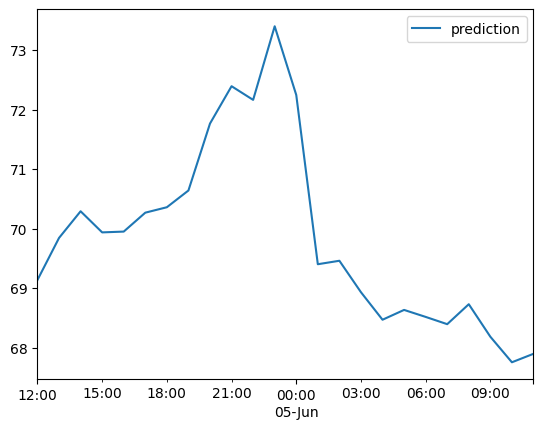

In [64]:
future_df.plot()

In [66]:
future_df.head()

,prediction
2025-06-04 12:00:00+03:00,69.140039
2025-06-04 13:00:00+03:00,69.846734
2025-06-04 14:00:00+03:00,70.295046
2025-06-04 15:00:00+03:00,69.939892
2025-06-04 16:00:00+03:00,69.953390


In [ ]:
peak_threshold.iloc[0]

np.float64(72.94220237741804)

In [ ]:
peak_threshold = future_df.quantile(0.98)
future_df["is_peak"] = future_df["prediction"] > peak_threshold.iloc[0]

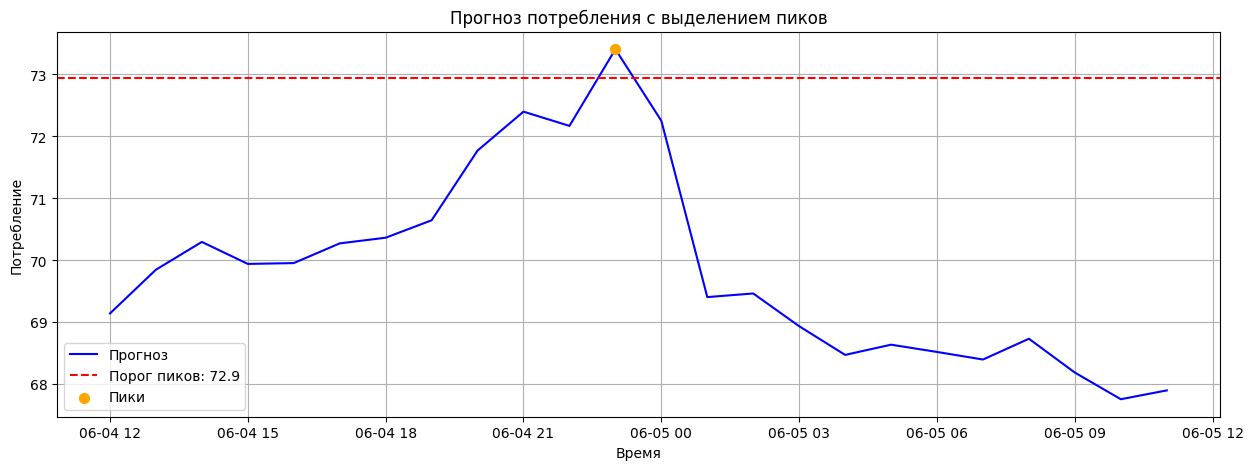

In [76]:
#plot with peaks
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
plt.plot(future_df.index, future_df['prediction'], label='Прогноз', color='blue')
plt.axhline(y=peak_threshold.iloc[0], color='red', linestyle='--', label=f'Порог пиков: {peak_threshold.iloc[0]:.1f}')
peak_indices = future_df[future_df['is_peak']].index
plt.scatter(peak_indices, future_df.loc[peak_indices, 'prediction'], color='orange', s=50, label='Пики', zorder=5)
plt.title('Прогноз потребления с выделением пиков')
plt.xlabel('Время')
plt.ylabel('Потребление')
plt.legend()
plt.grid()
plt.show()

In [44]:
future_df.head()

,prediction
2025-06-04 12:00:00+03:00,69.140039
2025-06-04 13:00:00+03:00,69.846734
2025-06-04 14:00:00+03:00,70.295046
2025-06-04 15:00:00+03:00,69.939892
2025-06-04 16:00:00+03:00,69.953390


In [23]:
df_enriched.head()

,import_diff,temperature,humidity,pressure,hour,day_of_week,is_weekend,month,season,import_lag_1,...,month_sin,month_cos,temperature_sin,temperature_cos,humidity_sin,humidity_cos,pressure_sin,pressure_cos,pressure_change,pressure_trend
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-05-10 00:00:00+03:00,58.0,5.9,81,1013.4,0,5,1,5,2,59.5,...,0.5,-0.866025,0.828009,0.560715,-0.929776,0.368125,-0.392911,0.919577,0.2,1012.350000
2025-05-10 01:00:00+03:00,58.0,5.4,84,1013.7,1,5,1,5,2,58.0,...,0.5,-0.866025,0.778877,0.627176,-0.844328,0.535827,-0.391310,0.920259,0.0,1012.700000
2025-05-10 02:00:00+03:00,58.0,5.1,85,1013.9,2,5,1,5,2,58.0,...,0.5,-0.866025,0.746821,0.665025,-0.809017,0.587785,-0.390242,0.920713,0.3,1013.050000
2025-05-10 03:00:00+03:00,58.0,4.8,86,1013.6,3,5,1,5,2,58.0,...,0.5,-0.866025,0.712928,0.701237,-0.770513,0.637424,-0.391843,0.920032,0.2,1013.350000
2025-05-10 04:00:00+03:00,57.0,4.6,83,1014.2,4,5,1,5,2,58.0,...,0.5,-0.866025,0.689353,0.724425,-0.876307,0.481754,-0.388638,0.921390,-0.3,1013.533333


In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def _to_naive_local(df: pd.DataFrame, tz: str = "Europe/Chisinau") -> pd.DataFrame:
    """
    Make index naive in local time without ever calling tz_localize.
    If tz-aware -> convert to `tz` then strip tz; if tz-naive -> leave as is.
    Also rounds to the nearest hour for clean joins.
    """
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("DataFrame must be indexed by timestamps (DatetimeIndex).")
    out = df.copy()
    if out.index.tz is not None:
        out.index = out.index.tz_convert(tz).tz_localize(None)
    # ensure exact-hour alignment
    out.index = out.index.round("H")
    return out

def evaluate_future_vs_truth(
    future_df: pd.DataFrame,
    df_enriched: pd.DataFrame,
    target_col: str = "import_diff",
    tz: str = "Europe/Chisinau",
    peak_q: float = 0.90,
):
    """
    Compare future_df['prediction'] vs df_enriched[target_col] over the overlapping hours.
    No tz-localize, no DST exception handling — just strip tz if present and align.
    """
    if "prediction" not in future_df.columns:
        raise ValueError("future_df must contain a 'prediction' column.")

    f = _to_naive_local(future_df[["prediction"]], tz)
    t = _to_naive_local(df_enriched[[target_col]].rename(columns={target_col: "actual"}), tz)

    # overlap window
    start = max(f.index.min(), t.index.min())
    end   = min(f.index.max(), t.index.max())
    comp = f.loc[start:end].join(t.loc[start:end], how="inner")

    if comp.empty:
        raise ValueError("No overlapping timestamps between forecast and truth.")

    # metrics
    y    = comp["actual"].astype(float).values
    yhat = comp["prediction"].astype(float).values
    resid = yhat - y

    mae  = float(np.mean(np.abs(resid)))
    rmse = float(np.sqrt(np.mean(resid**2)))
    smape = float(100 * np.mean(2 * np.abs(yhat - y) / (np.abs(yhat) + np.abs(y) + 1e-9)))
    wmape = float(100 * np.sum(np.abs(resid)) / (np.sum(np.abs(y)) + 1e-9))
    metrics = {"MAE": mae, "RMSE": rmse, "sMAPE_%": smape, "wMAPE_%": wmape}

    # peak metrics (simple)
    thr = float(np.quantile(comp["actual"], peak_q))
    comp["true_peak"] = (comp["actual"] > thr).astype(int)
    comp["pred_peak"] = (comp["prediction"] > thr).astype(int)
    tp = int(((comp["true_peak"] == 1) & (comp["pred_peak"] == 1)).sum())
    fp = int(((comp["true_peak"] == 0) & (comp["pred_peak"] == 1)).sum())
    fn = int(((comp["true_peak"] == 1) & (comp["pred_peak"] == 0)).sum())
    precision = float(tp / (tp + fp)) if (tp + fp) else 0.0
    recall    = float(tp / (tp + fn)) if (tp + fn) else 0.0
    f1        = float(2 * precision * recall / (precision + recall)) if (precision + recall) else 0.0
    peak_metrics = {"threshold": thr, "precision": precision, "recall": recall, "f1": f1, "tp": tp, "fp": fp, "fn": fn}

    # ---- plots ----
    # 1) Time series
    fig1, ax1 = plt.subplots(figsize=(12, 4))
    comp["actual"].plot(ax=ax1, lw=1.2, label="Actual")
    comp["prediction"].plot(ax=ax1, lw=1.2, label="Prediction")
    ax1.axhline(thr, ls="--", lw=1.0, label=f"Peak q{int(peak_q*100)}")
    ax1.set_title("Actual vs Prediction")
    ax1.set_ylabel("kWh")
    ax1.legend(loc="upper left")
    plt.tight_layout()

    # 2) Residuals
    fig2, ax2 = plt.subplots(figsize=(12, 3))
    pd.Series(resid, index=comp.index).plot(ax=ax2, lw=1.0)
    ax2.axhline(0.0, lw=1.0)
    ax2.set_title("Residuals (Prediction - Actual)")
    ax2.set_ylabel("kWh")
    plt.tight_layout()

    # 3) Scatter
    fig3, ax3 = plt.subplots(figsize=(4.5, 4.5))
    ax3.scatter(comp["actual"], comp["prediction"], s=14)
    lims = [min(comp["actual"].min(), comp["prediction"].min()),
            max(comp["actual"].max(), comp["prediction"].max())]
    ax3.plot(lims, lims)
    ax3.set_xlabel("Actual")
    ax3.set_ylabel("Prediction")
    ax3.set_title("Actual vs Prediction")
    plt.tight_layout()

    # 4) MAE by hour of day
    comp["hour"] = comp.index.hour
    hod_mae = comp.groupby("hour").apply(lambda d: np.mean(np.abs(d["actual"] - d["prediction"])))
    fig4, ax4 = plt.subplots(figsize=(7, 3.5))
    ax4.bar(hod_mae.index.astype(int), hod_mae.values)
    ax4.set_xlabel("Hour of day")
    ax4.set_ylabel("MAE")
    ax4.set_title("MAE by Hour of Day")
    plt.tight_layout()

    return {"aligned": comp, "metrics": metrics, "peak_metrics": peak_metrics,
            "hod_mae": hod_mae, "figures": {"ts": fig1, "resid": fig2, "scatter": fig3, "hod": fig4}}


In [ ]:
res = evaluate_forecast(
    future_df=future_df,         # has 'prediction'
    df_enriched=df_enriched,     # has 'import_diff'
    target_col="import_diff",
    tz="Europe/Chisinau",        # keep consistent with your data
    peak_q=0.90
)

print("Metrics:", res["metrics"])
print("Peak metrics:", res["peaks"])
res["aligned"].head()


In [33]:
future_df.head()

,prediction
2025-06-08 16:00:00+03:00,70.686189
2025-06-08 17:00:00+03:00,71.004140
2025-06-08 18:00:00+03:00,70.549892
2025-06-08 19:00:00+03:00,70.892697
2025-06-08 20:00:00+03:00,72.453673


In [35]:
df_enriched.tail()

,import_diff,temperature,humidity,pressure,hour,day_of_week,is_weekend,month,season,import_lag_1,...,month_sin,month_cos,temperature_sin,temperature_cos,humidity_sin,humidity_cos,pressure_sin,pressure_cos,pressure_change,pressure_trend
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-06-08 11:00:00+03:00,77.00,26.6,47,1010.0,11,6,1,6,3,90.00,...,1.224647e-16,-1.0,-0.951057,-0.309017,0.187381,-0.982287,-0.410972,0.911648,-0.1,1010.333333
2025-06-08 12:00:00+03:00,23.25,28.4,41,1009.8,12,6,1,6,3,77.00,...,1.224647e-16,-1.0,-0.999863,-0.016534,0.535827,-0.844328,-0.412030,0.911170,-0.1,1010.266667
2025-06-08 13:00:00+03:00,167.00,29.7,35,1009.4,13,6,1,6,3,23.25,...,1.224647e-16,-1.0,-0.980380,0.197117,0.809017,-0.587785,-0.414143,0.910212,-0.2,1010.150000
2025-06-08 14:00:00+03:00,209.00,30.5,31,1008.8,14,6,1,6,3,167.00,...,1.224647e-16,-1.0,-0.945817,0.324699,0.929776,-0.368125,-0.417309,0.908765,-0.4,1009.966667
2025-06-08 15:00:00+03:00,70.50,30.9,28,1008.3,15,6,1,6,3,209.00,...,1.224647e-16,-1.0,-0.922290,0.386499,0.982287,-0.187381,-0.419944,0.907550,-0.6,1009.716667


In [10]:
import pandas as pd
import numpy as np
import requests

def _as_tz(ts, tz: str) -> pd.Timestamp:
    ts = pd.Timestamp(ts)
    return ts.tz_localize(tz) if ts.tz is None else ts.tz_convert(tz)

def get_unified_weather_data(start_date: pd.Timestamp,
                             end_date: pd.Timestamp,
                             lat: float = 47.01,
                             lon: float = 28.86,
                             tz: str = "Europe/Chisinau") -> pd.DataFrame:
    """
    Return hourly weather (temperature, humidity, pressure) with a tz-aware index in `tz`.
    Combines Open-Meteo archive (past) + forecast (future) and slices to [start_date, end_date].
    """
    # --- normalize inputs to tz-aware and hour grid ---
    start = _as_tz(start_date, tz).floor("H")
    end   = _as_tz(end_date,   tz).ceil("H")
    now   = pd.Timestamp.now(tz=tz).floor("H")

    parts = []

    # --------- Part 1: archive (past) ----------
    hist_start = start
    hist_end   = min(now - pd.Timedelta(hours=1), end)  # archive reliable up to last full hour
    if hist_start <= hist_end:
        api_url = (
            "https://archive-api.open-meteo.com/v1/archive?"
            f"latitude={lat}&longitude={lon}"
            f"&start_date={hist_start.date().isoformat()}&end_date={hist_end.date().isoformat()}"
            "&hourly=temperature_2m,relative_humidity_2m,surface_pressure"
            f"&timezone={tz}"
        )
        r = requests.get(api_url, timeout=30); r.raise_for_status()
        h = r.json()["hourly"]
        df_hist = pd.DataFrame(h)
        df_hist["time"] = pd.to_datetime(df_hist["time"])
        # IMPORTANT: strings are in local clock; assign tz (do not convert)
        df_hist["time"] = df_hist["time"].dt.tz_localize(tz)
        parts.append(df_hist)

    # --------- Part 2: forecast (future) ----------
    fc_start = max(start, now)
    if fc_start <= end:
        forecast_hours = int((end - now).total_seconds() // 3600) + 1
        api_url = (
            "https://api.open-meteo.com/v1/forecast?"
            f"latitude={lat}&longitude={lon}"
            "&hourly=temperature_2m,relative_humidity_2m,surface_pressure"
            f"&forecast_hours={forecast_hours}&timezone={tz}"
        )
        r = requests.get(api_url, timeout=30); r.raise_for_status()
        f = r.json()["hourly"]
        df_fc = pd.DataFrame(f)
        df_fc["time"] = pd.to_datetime(df_fc["time"])
        # IMPORTANT: assign tz (do not convert)
        df_fc["time"] = df_fc["time"].dt.tz_localize(tz)
        parts.append(df_fc)

    if not parts:
        return pd.DataFrame(columns=["temperature","humidity","pressure"]).set_index(
            pd.DatetimeIndex([], tz=tz)
        )

    # --------- Combine, clean, slice ----------
    df = (pd.concat(parts, ignore_index=True)
            .drop_duplicates(subset=["time"])
            .set_index("time")
            .sort_index()
            .rename(columns={
                "temperature_2m": "temperature",
                "relative_humidity_2m": "humidity",
                "surface_pressure": "pressure",
            }))

    # ensure hourly grid (nearest within 1h) and slice exact window
    df = df.resample("H").nearest(limit=1)
    df = df.loc[start:end]

    # fill any tiny gaps defensively
    if df.isna().any().any():
        df = df.fillna(method="ffill").fillna(method="bfill")

    return df


In [15]:

def predict_future(
    model: cb.CatBoostRegressor,
    raw_historical_df: pd.DataFrame,
    future_steps: int,
    feature_creation_function: callable,
    max_lag: int = 168,
    tz: str = 'Europe/Chisinau'
) -> pd.DataFrame:
    """
    Performs an EFFICIENT autoregressive forecast for a specified number of future steps
    using a rolling window approach to avoid re-calculating features for the entire history.

    Args:
        model: The trained CatBoost model.
        raw_historical_df: DataFrame of historical data BEFORE feature engineering.
                           Must contain the target ('import_diff') and weather columns.
        future_steps: The number of hours to forecast into the future.
        feature_creation_function: Reference to the function that creates features.
        max_lag: The largest lag used in feature engineering (e.g., 168 for a week).
                 This determines the size of the rolling window.
        tz: The timezone for all date operations.

    Returns:
        A DataFrame containing the future predictions.
    """
    print(f"Starting EFFICIENT autoregressive forecast for {future_steps} steps...")
    
    # --- FIX 1: Ensure the historical DataFrame's index is timezone-aware ---
    if raw_historical_df.index.tz is None:
        print(f"Localizing historical data to timezone: {tz}")
        raw_historical_df.index = raw_historical_df.index.tz_localize(tz)
    
    # 1. Use a "lookback window" of recent history, which is all we need.
    history_window = raw_historical_df.iloc[-max_lag:].copy()

    # 2. Get weather forecast for the entire future period
    last_timestamp = raw_historical_df.index.max()
    forecast_start_time = last_timestamp + pd.Timedelta(hours=1)
    forecast_end_time = last_timestamp + pd.Timedelta(hours=future_steps)
    
    unified_weather_df = get_unified_weather_data(
        start_date=forecast_start_time, 
        end_date=forecast_end_time,
        tz=tz
    )
    
    # --- FIX 2: Forward-fill any gaps in the weather data to prevent NaNs ---
    if unified_weather_df.isnull().values.any():
        print("Warning: Missing values found in weather data. Forward-filling.")
        unified_weather_df = unified_weather_df.ffill().bfill() # bfill for any leading NaNs


    predictions = []
    
    # 3. Iteratively predict one step at a time
    for i in range(future_steps):
        current_timestamp = last_timestamp + pd.Timedelta(hours=i + 1)
        
        # Create a shell for the next step to be predicted
        next_step_shell = pd.DataFrame(index=[current_timestamp])
        next_step_shell['import_diff'] = np.nan # Placeholder for the target
        
        # Add future weather data to the shell
        try:
            weather_now = unified_weather_df.loc[current_timestamp]
            for col in weather_now.index:
                next_step_shell[col] = weather_now[col]
        except KeyError:
            print(f"Warning: Weather data not available for {current_timestamp}. Using last known values.")
            last_weather = history_window[['temperature', 'humidity', 'pressure']].iloc[-1]
            for col in last_weather.index:
                next_step_shell[col] = last_weather[col]

        # Combine our rolling history window with the new shell
        combined_window = pd.concat([history_window, next_step_shell])
        
        # Generate features ONLY for this small, combined window.
        df_with_features = feature_creation_function(combined_window)
        
        # The features for our prediction are in the very last row
        features_for_pred = df_with_features.drop('import_diff', axis=1).iloc[-1:]
        
        # --- FIX 3: Add a safeguard check before prediction ---
        if features_for_pred.empty:
            raise RuntimeError(
                f"Feature engineering resulted in an empty DataFrame at timestamp {current_timestamp}. "
                "This is likely due to NaNs being created and then dropped. "
                "Check for missing weather data or issues in the feature creation logic."
            )
        
        # Make the prediction
        prediction = model.predict(features_for_pred)[0]
        predictions.append(prediction)
        
        # This is the crucial step: update the history window for the next iteration.
        # First, complete the shell with the prediction we just made.
        next_step_shell['import_diff'] = prediction
        
        # Append this completed row to our history window
        history_window = pd.concat([history_window, next_step_shell])
        
        # And drop the oldest row to keep the window size constant, "rolling" it forward.
        history_window = history_window.iloc[1:]

    # 4. Create the final results DataFrame
    future_index = pd.date_range(
        start=last_timestamp + pd.Timedelta(hours=1), 
        periods=future_steps, 
        freq='h',
        tz=tz # Ensure the final index is also timezone-aware
    )
    df_forecast = pd.DataFrame(data={'prediction': predictions}, index=future_index)
    
    print("Forecast complete.")
    return df_forecast


In [16]:
future_df = predict_future(
    model=loaded_model,
    raw_historical_df=df_enriched,
    future_steps=24,
    feature_creation_function=loader.create_advanced_features
)

Starting EFFICIENT autoregressive forecast for 24 steps...


/tmp/ipykernel_161155/908122090.py:19: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start = _as_tz(start_date, tz).floor("H")
/tmp/ipykernel_161155/908122090.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  end   = _as_tz(end_date,   tz).ceil("H")
/tmp/ipykernel_161155/908122090.py:21: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  now   = pd.Timestamp.now(tz=tz).floor("H")
/tmp/ipykernel_161155/908122090.py:79: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample("H").nearest(limit=1)


Forecast complete.


In [17]:
import pandas as pd
import numpy as np
import inspect

def _ensure_tz_aware_index(df: pd.DataFrame, tz: str) -> pd.DataFrame:
    if df.index.tz is None:
        df = df.copy()
        df.index = df.index.tz_localize(tz)
    else:
        df = df.tz_convert(tz)
    return df

def _detect_warmup_len(raw_df: pd.DataFrame,
                       make_feats: callable,
                       base_len: int,
                       tz: str,
                       max_cap_hours: int = 24*60,
                       step_hours: int = 24) -> int:
    """
    Find minimal lookback length so that the feature builder produces a row
    for the last timestamp (i.e., it doesn't drop it due to lags/rollings).
    """
    raw_df = _ensure_tz_aware_index(raw_df, tz)
    N = len(raw_df)
    if N == 0:
        raise ValueError("raw_historical_df is empty")

    L = min(max(base_len, 1), N)
    while True:
        window = raw_df.iloc[-L:].copy()
        feats = make_feats(window)
        # if function returns a DF with the last timestamp intact => success
        if len(feats) and feats.index[-1] == window.index[-1]:
            return L
        # Try a non-dropping call if the function supports it
        sig = inspect.signature(make_feats)
        if "dropna" in sig.parameters:
            feats2 = make_feats(window, dropna=False)
            if len(feats2) and feats2.index[-1] == window.index[-1]:
                return L
        # Otherwise, increase the window
        if L >= N or L >= max_cap_hours:
            # give up: use all available history
            return N
        L = min(L + step_hours, N)

def predict_future2(
    model,
    raw_historical_df: pd.DataFrame,
    future_steps: int,
    feature_creation_function: callable,
    max_lag: int = 168,
    tz: str = "Europe/Chisinau",
    target_col: str = "import_diff",
    weather_cols = ("temperature", "humidity", "pressure"),
    get_weather_fn = None,   # optional override, defaults to your get_unified_weather_data
):
    """
    Efficient 1-step recursive forecast with dynamic warmup detection.
    """
    print(f"Starting EFFICIENT autoregressive forecast for {future_steps} steps...")

    # 0) TZ normalize
    raw_historical_df = _ensure_tz_aware_index(raw_historical_df, tz)

    # 1) Determine how much history your feature builder actually needs
    warmup_len = _detect_warmup_len(raw_historical_df, feature_creation_function, max_lag, tz)
    if warmup_len > max_lag:
        print(f"[info] Increasing lookback from {max_lag} → {warmup_len} to satisfy feature warmup.")
    history_window = raw_historical_df.iloc[-warmup_len:].copy()

    # 2) Weather for the whole future horizon
    last_ts = raw_historical_df.index.max()
    forecast_start_time = last_ts + pd.Timedelta(hours=1)
    forecast_end_time   = last_ts + pd.Timedelta(hours=future_steps)

    if get_weather_fn is None:
        # use your existing function
        unified_weather_df = get_unified_weather_data(
            start_date=forecast_start_time,
            end_date=forecast_end_time,
            tz=tz
        )
    else:
        unified_weather_df = get_weather_fn(
            start_date=forecast_start_time,
            end_date=forecast_end_time,
            tz=tz
        )

    # 3) Recursive prediction
    predictions = []
    sig = inspect.signature(feature_creation_function)
    supports_dropna = "dropna" in sig.parameters

    for i in range(future_steps):
        current_ts = last_ts + pd.Timedelta(hours=i + 1)

        # Prepare one-step shell
        next_row = pd.DataFrame(index=[current_ts])
        next_row[target_col] = np.nan

        # Attach weather
        if current_ts in unified_weather_df.index:
            w = unified_weather_df.loc[current_ts]
        else:
            # persistence fallback
            w = history_window[list(weather_cols)].iloc[-1]
        for col in weather_cols:
            next_row[col] = w[col]

        # Combine with rolling history
        combined = pd.concat([history_window, next_row])

        # Build features on the small combined window
        feats = feature_creation_function(combined)
        # If your function dropped the last row, try non-dropping mode if available
        if (len(feats) == 0 or feats.index[-1] != current_ts) and supports_dropna:
            feats = feature_creation_function(combined, dropna=False)

        # If still empty (not enough history), expand the window once more dynamically
        if len(feats) == 0 or feats.index[-1] != current_ts:
            # Pull more history (up to all) and retry once
            extra_need = 24
            start_pos = max(0, len(raw_historical_df) - (warmup_len + extra_need))
            history_window = raw_historical_df.iloc[start_pos:len(raw_historical_df)].copy()
            combined = pd.concat([history_window, next_row])
            feats = (feature_creation_function(combined, dropna=False)
                     if supports_dropna else feature_creation_function(combined))
            if len(feats) == 0 or feats.index[-1] != current_ts:
                raise RuntimeError(
                    "Feature builder still drops the last row. "
                    "Ensure your feature_creation_function supports dropna=False "
                    "or increase lags/roll windows handling."
                )

        X_pred = feats.drop(columns=[target_col], errors="ignore").iloc[[-1]]
        if X_pred.shape[0] == 0:
            raise RuntimeError("No feature row for the current timestamp; X_pred is empty.")

        yhat = float(model.predict(X_pred)[0])
        predictions.append(yhat)

        # Roll the window: commit the prediction
        next_row[target_col] = yhat
        history_window = pd.concat([history_window, next_row]).iloc[1:]

    # 4) Output DF
    future_index = pd.date_range(
        start=forecast_start_time, periods=future_steps, freq="H", tz=tz
    )
    df_forecast = pd.DataFrame({"prediction": predictions}, index=future_index)
    print("Forecast complete.")
    return df_forecast


In [18]:
future_df2 = predict_future(
    model=loaded_model,
    raw_historical_df=df_enriched,
    future_steps=24,
    feature_creation_function=loader.create_advanced_features
)

Starting EFFICIENT autoregressive forecast for 24 steps...


/tmp/ipykernel_161155/908122090.py:19: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start = _as_tz(start_date, tz).floor("H")
/tmp/ipykernel_161155/908122090.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  end   = _as_tz(end_date,   tz).ceil("H")
/tmp/ipykernel_161155/908122090.py:21: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  now   = pd.Timestamp.now(tz=tz).floor("H")
/tmp/ipykernel_161155/908122090.py:79: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample("H").nearest(limit=1)


Forecast complete.


<Axes: >

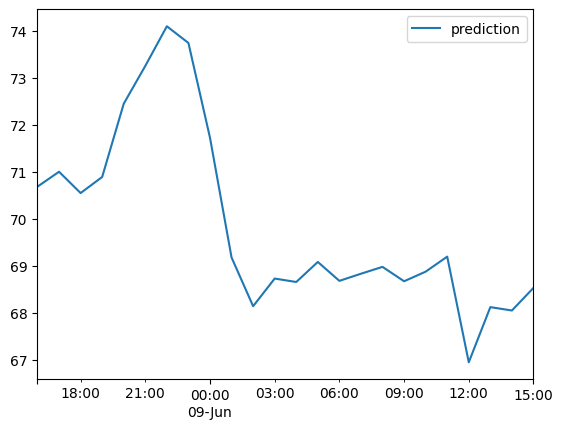

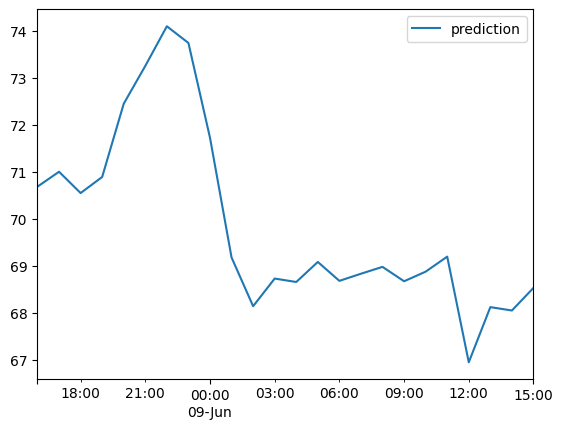

In [21]:
future_df.plot()
future_df2.plot()